In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from fastai import *
from fastai.text import *

import re
import sentencepiece as spm #https://github.com/google/sentencepiece

In [4]:
np.random.seed(20190123)

In [5]:
PATH = Path('/home/farzin/rnn_python_code/wiki103_from_download')

In [202]:
!du -h {PATH}

1.2G	/home/farzin/rnn_python_code/wiki103_from_download/tmp_bwd
1.2G	/home/farzin/rnn_python_code/wiki103_from_download/tmp
1.3G	/home/farzin/rnn_python_code/wiki103_from_download/sp_tokenizer
225M	/home/farzin/rnn_python_code/wiki103_from_download/lm/lm_data
861M	/home/farzin/rnn_python_code/wiki103_from_download/lm/models
1.1G	/home/farzin/rnn_python_code/wiki103_from_download/lm
225M	/home/farzin/rnn_python_code/wiki103_from_download/lm_bwd/lm_data_bwd
1.1G	/home/farzin/rnn_python_code/wiki103_from_download/lm_bwd/models
1.3G	/home/farzin/rnn_python_code/wiki103_from_download/lm_bwd
1.6G	/home/farzin/rnn_python_code/wiki103_from_download/clas/models
1.6G	/home/farzin/rnn_python_code/wiki103_from_download/clas
2.3G	/home/farzin/rnn_python_code/wiki103_from_download/models
906M	/home/farzin/rnn_python_code/wiki103_from_download/clas_bwd/models
906M	/home/farzin/rnn_python_code/wiki103_from_download/clas_bwd
11G	/home/farzin/rnn_python_code/wiki103_from_download


In [201]:
!tree {PATH}

/home/farzin/rnn_python_code/wiki103_from_download
├── clas
│   └── models
│       ├── final_FL.pth
│       ├── final.pth
│       ├── fine_tuned_enc60kb.pth -> ../../lm/models/fine_tuned_enc60kb.pth
│       ├── second_FL.pth
│       ├── second.pth
│       ├── third_FL.pth
│       ├── third.pth
│       └── tmp.pth
├── clas_bwd
│   └── models
│       ├── final_bwd.pth
│       ├── fine_tuned60kb_bwd.pth -> ../../lm_bwd/models/fine_tuned60kb_bwd.pth
│       ├── fine_tuned_enc60kb_bwd.pth -> ../../lm_bwd/models/fine_tuned_enc60kb_bwd.pth
│       ├── second_bwd.pth
│       ├── third_bwd.pth
│       └── tmp.pth
├── lm
│   ├── lm_data
│   │   ├── classes.txt
│   │   ├── itos.pkl
│   │   ├── train_ids.npy
│   │   ├── train_lbl.npy
│   │   ├── valid_ids.npy
│   │   └── valid_lbl.npy
│   └── models
│       ├── fine_tuned60kb.pth
│       ├── fine_tuned_enc60kb.pth
│       ├── fit_head.pth
│       ├── itos_raw_spacy.pkl -> ../../models/itos_raw_spacy.pkl
│       ├── tmp.pth -> ../../models/tmp.pth


### Pull and prep IMDB data for supervised and unsupervised step

In [6]:
IMDB_PATH = untar_data(URLs.IMDB)
IMDB_PATH

PosixPath('/home/farzin/.fastai/data/imdb')

In [7]:
CLAS_PATH = PATH/'clas'
LM_PATH = PATH/'lm'
os.makedirs(CLAS_PATH, exist_ok=True)
os.makedirs(LM_PATH, exist_ok=True)

In [8]:
## raw data does not have the unsup in the train directory.  Just move it there
#  ~/.fastai/data/imdb$ mv unsup/ ./train/
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels,scores = [],[],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r', encoding='utf8').read())
            labels.append(idx)
            review_name = listify(fname.parts)[-1].split('.')[0]
            scores.append( int(review_name.split("_")[1]) )

    return np.array(texts),np.array(labels),np.array(scores)

train_texts,train_labels,train_scr = get_texts(IMDB_PATH/'train')
valid_texts,valid_labels,valid_scr = get_texts(IMDB_PATH/'test')

In [9]:
len(train_texts),len(valid_texts)

(75000, 25000)

In [10]:
train_idx = np.random.permutation(len(train_texts))
valid_idx = np.random.permutation(len(valid_texts))

train_texts,train_labels,train_scr = train_texts[train_idx],train_labels[train_idx],train_scr[train_idx]
valid_texts,valid_labels,valid_scr = valid_texts[valid_idx],valid_labels[valid_idx],valid_scr[valid_idx]

In [11]:
train_df = pd.DataFrame({'text':train_texts, 'labels':train_labels, 'rating':train_scr}, columns=['labels','text','rating'])
valid_df = pd.DataFrame({'text':valid_texts, 'labels':valid_labels, 'rating':valid_scr}, columns=['labels','text','rating'])

In [12]:
for this_cls in range(3):
    print(train_df[train_df.labels == this_cls]['rating'].value_counts())

1    5100
4    2696
3    2420
2    2284
Name: rating, dtype: int64
10    4732
8     3009
7     2496
9     2263
Name: rating, dtype: int64
0    50000
Name: rating, dtype: int64


In [13]:
all_texts = np.concatenate([train_texts,valid_texts])
idx = np.random.permutation(len(all_texts))
cut = int(0.1 * len(idx))
LM_train_df = pd.DataFrame({'text':all_texts[idx[cut:]], 'labels':[0] * (len(all_texts)-cut)}, columns=['labels','text'])
LM_valid_df = pd.DataFrame({'text':all_texts[idx[:cut]], 'labels':[0] * cut}, columns=['labels','text'])

In [14]:
len(all_texts),len(LM_train_df),len(LM_valid_df)

(100000, 90000, 10000)

In [15]:
LM_train_df.head()

,labels,text
0,0,Simply boring! This is one of the worst movies...
1,0,"After you've watched The Love Bug, you will no..."
2,0,The third Muppet movie is perhaps the most rel...
3,0,"A movie like the life - complex, with unexpect..."
4,0,<br /><br />I didn´t enjoy the film at all. Th...


In [16]:
CLS_train_df = train_df[train_df.labels != 2]
CLS_valid_df = valid_df[valid_df.labels != 2]
CLS_train_df.head()

,labels,text,rating
0,0,Another trashy Grade Z quickie from the prolif...,1
1,0,"This show stinks. For parents, they usually wa...",2
5,1,Just two comments....SEVEN years apart? Hardly...,7
8,0,SOME NOT-SO-SPOILY SPOILERS AHEAD<br /><br />W...,4
10,1,"This is a very funny movie, easy to watch, tha...",7


### Tokenizer

In [17]:
def sub_br(t:str) -> str:
    "Replaces the <br /> by \n"
    re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
    return re_br.sub("\n", t)

def spec_add_spaces(t:str) -> str:
    "Add spaces between special characters"
    return re.sub(r'([/#])', r' \1 ', t)

def rm_useless_spaces(t:str) -> str:
    "Remove multiple spaces"
    return re.sub(' {2,}', ' ', t)

def replace_rep(t:str) -> str:
    "Replace repetitions at the character level"
    def _replace_rep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)
    
def replace_wrep(t:str) -> str:
    "Replace word repetitions"
    def _replace_wrep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_WREP} {len(cc.split())+1} {c} '
    re_wrep = re.compile(r'(\b\w+\W+)(\1{3,})')
    return re_wrep.sub(_replace_wrep, t)

def deal_caps(t:str) -> str:
    "Replace words in all caps"
    res = []
    for s in re.findall(r'\w+|\W+', t):
        res += ([f' {TK_UP} ',s.lower()] if (s.isupper() and (len(s)>2)) else [s.lower()])
    return ''.join(res)

def fixup(x:str) -> str:
    "List of replacements from html strings"
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>',UNK).replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

default_rules = [fixup, replace_rep, replace_wrep, deal_caps, spec_add_spaces, rm_useless_spaces, sub_br]
default_spec_tok = [BOS, FLD, UNK, PAD]


tokenizer = Tokenizer(pre_rules=default_rules, special_cases=[BOS, FLD, 'xxunk', 'xxpad'], n_cpus=4)
tokenizer

Tokenizer SpacyTokenizer in en with the following rules:
 - fixup
 - replace_rep
 - replace_wrep
 - deal_caps
 - spec_add_spaces
 - rm_useless_spaces
 - sub_br
 - replace_all_caps
 - deal_caps

### Build LM DataBunch

In [18]:
max_vocab = 60000 #can we make this the full possible vocab at 260k?

keyword_args = {'max_vocab':max_vocab}
imdb_data_lm = TextLMDataBunch.from_df(LM_PATH, LM_train_df, LM_valid_df, tokenizer=tokenizer,
                               text_cols='text', label_cols='labels',**keyword_args)

In [ ]:
imdb_data_lm.save('lm_data')

### finetune LM

In [19]:
bptt = 140
emb_sz,nh,nl = 400,1111,4

In [ ]:
learn = language_model_learner(imdb_data_lm,bptt,emb_sz,nh,nl,drop_mult=0.5,qrnn=True, 
                               pretrained_fnames=['wiki103_raw_articles_spacy_20190123',
                                                  'itos_raw_spacy'])
learn.freeze()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7), wd=0.03, pct_start=0.25)

In [ ]:
learn.save('fit_head')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.9,0.75), wd=0.01, pct_start=0.25)

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('fine_tuned60kb')
learn.save_encoder('fine_tuned_enc60kb')

In [ ]:
learn.load('fine_tuned60kb')

### Build/train classifier

In [20]:
CLS_train_df.head()

,labels,text,rating
0,0,Another trashy Grade Z quickie from the prolif...,1
1,0,"This show stinks. For parents, they usually wa...",2
5,1,Just two comments....SEVEN years apart? Hardly...,7
8,0,SOME NOT-SO-SPOILY SPOILERS AHEAD<br /><br />W...,4
10,1,"This is a very funny movie, easy to watch, tha...",7


In [21]:
imdb_data_clas = TextClasDataBunch.from_df(CLAS_PATH,CLS_train_df,CLS_valid_df, tokenizer=tokenizer,
                                           vocab=imdb_data_lm.train_ds.vocab,label_cols='labels',text_cols='text')

In [140]:
del learn
torch.cuda.empty_cache()

In [141]:
imdb_data_clas.batch_size = 16
learn_cls = text_classifier_learner(imdb_data_clas,bptt,emb_sz,nh,nl,drop_mult=0.5,qrnn=True)
learn_cls.load_encoder('fine_tuned_enc60kb')
learn_cls.freeze()
learn_cls

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (25000 items)
[Category 0, Category 0, Category 1, Category 0, Category 1]...
Path: /home/farzin/rnn_python_code/wiki103_from_download/clas
x: TextList (25000 items)
[Text xxbos another trashy grade z quickie from the prolific albert pyun . tim xxunk 13 inch clint eastwood - like cop from outer space chases an ugly flying head ( ! ) to earth and gets involved in a gang war in south bronx ! mercifully short , but xxunk dull , with the cheesiest effects since attack of the 50 ft woman . they should have fired the continuity guy , too : note how xxunk sunglasses disappears and reappears in every second shot . laughably bad , but that´s why we watch these movies , xxunk it ? sequel ´ dollman vs. demonic toys ´ is reportedly even worse , if that´s possible . 

 0 ( of xxrep 4 * ) 

, Text xxbos this show stinks . for parents , they usually want their kids to watch something good for them . it is usually educational , funny

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


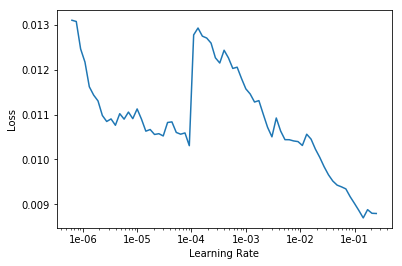

In [27]:
lr_find(learn_cls)
learn_cls.recorder.plot()

In [28]:
learn_cls.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.001525,0.001160,0.904160


In [29]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.001642,0.001391,0.882240
2,0.001462,0.001112,0.916280


In [39]:
learn_cls.fit_one_cycle(4, 2e-2, moms=(0.8,0.7),pct_start=0.15)

epoch,train_loss,valid_loss,accuracy
1,0.001766,0.006221,0.876840
2,0.001598,0.001066,0.913800
3,0.001562,0.001034,0.915000
4,0.001492,0.001080,0.917400


In [40]:
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(4, slice(2e-2/2.6,1e-2), moms=(0.8,0.7), pct_start=0.15)

epoch,train_loss,valid_loss,accuracy
1,0.001524,0.001303,0.917280
2,0.001371,0.000977,0.923880
3,0.001481,0.001026,0.930000
4,0.001248,0.000950,0.932240


In [41]:
learn_cls.save('second_FL')

In [46]:
learn_cls.load('second_FL')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (25000 items)
[Category 0, Category 0, Category 1, Category 0, Category 1]...
Path: /home/farzin/rnn_python_code/wiki103_from_download/clas
x: TextList (25000 items)
[Text xxbos another trashy grade z quickie from the prolific albert pyun . tim xxunk 13 inch clint eastwood - like cop from outer space chases an ugly flying head ( ! ) to earth and gets involved in a gang war in south bronx ! mercifully short , but xxunk dull , with the cheesiest effects since attack of the 50 ft woman . they should have fired the continuity guy , too : note how xxunk sunglasses disappears and reappears in every second shot . laughably bad , but that´s why we watch these movies , xxunk it ? sequel ´ dollman vs. demonic toys ´ is reportedly even worse , if that´s possible . 

 0 ( of xxrep 4 * ) 

, Text xxbos this show stinks . for parents , they usually want their kids to watch something good for them . it is usually educational , funny

In [47]:
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(4, slice(2e-2/(2.6**2),0.5e-2), moms=(0.8,0.7), pct_start=0.15)

epoch,train_loss,valid_loss,accuracy
1,0.001378,0.000970,0.931120
2,0.001321,0.001231,0.932960
3,0.001240,0.001065,0.934360
4,0.001089,0.001199,0.939760


In [48]:
learn_cls.save('third_FL')

In [84]:
learn_cls.load('third_FL')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (25000 items)
[Category 0, Category 0, Category 1, Category 0, Category 1]...
Path: /home/farzin/rnn_python_code/wiki103_from_download/clas
x: TextList (25000 items)
[Text xxbos another trashy grade z quickie from the prolific albert pyun . tim xxunk 13 inch clint eastwood - like cop from outer space chases an ugly flying head ( ! ) to earth and gets involved in a gang war in south bronx ! mercifully short , but xxunk dull , with the cheesiest effects since attack of the 50 ft woman . they should have fired the continuity guy , too : note how xxunk sunglasses disappears and reappears in every second shot . laughably bad , but that´s why we watch these movies , xxunk it ? sequel ´ dollman vs. demonic toys ´ is reportedly even worse , if that´s possible . 

 0 ( of xxrep 4 * ) 

, Text xxbos this show stinks . for parents , they usually want their kids to watch something good for them . it is usually educational , funny

In [85]:
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(10, slice(2e-2/(2.6**2),0.5e-2), moms=(0.8,0.7), pct_start=0.15)

epoch,train_loss,valid_loss,accuracy
1,0.001174,0.000905,0.937040
2,0.001196,0.002835,0.934200
3,0.001240,0.001111,0.922680
4,0.001220,0.001715,0.936200
5,0.001145,0.003396,0.937120
6,0.001128,0.001309,0.929960
7,0.001098,0.001614,0.938920
8,0.001044,0.001077,0.939360
9,0.000944,0.001018,0.940560
10,0.000989,0.001043,0.939720


In [86]:
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(10, slice(2e-2/(2.6**2),0.5e-2), moms=(0.8,0.7), pct_start=0.15)

epoch,train_loss,valid_loss,accuracy
1,0.001006,0.001035,0.932560
2,0.001312,0.001208,0.922760
3,0.001123,0.045645,0.935200
4,0.001225,0.001308,0.935320
5,0.001143,0.001212,0.937600
6,0.001015,0.001129,0.938520
7,0.001104,0.001184,0.938560
8,0.000975,0.001963,0.939840
9,0.000869,0.001018,0.940840
10,0.000872,0.001138,0.942040


In [92]:
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(0.5e-2/(2.6**4),0.25e-2), moms=(0.8,0.7), pct_start=0.1) #, wd=1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.000831,0.000909,0.939440
2,0.000910,0.001380,0.940200
3,0.000729,0.001617,0.941680
4,0.000885,0.001104,0.943560


In [110]:
learn_cls.fit_one_cycle(10, slice(0.75e-2/(2.6**4),0.5e-2), moms=(0.8,0.7), pct_start=0.05) #, wd=1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.000946,0.001049,0.942040
2,0.000854,0.001057,0.931520
3,0.000906,0.001126,0.941280
4,0.000902,0.001153,0.940440
5,0.000672,0.001010,0.938960
6,0.000642,0.001117,0.941120
7,0.000608,0.001017,0.938160
8,0.000500,0.001031,0.941800
9,0.000460,0.001152,0.939520
10,0.000523,0.001112,0.940560


In [126]:
learn_cls.save('final_FL')

In [ ]:
del learn_cls
torch.cuda.empty_cache()

### Try FocalLoss to refine the fit?  Get those marginal cases?

In [ ]:
learn_cls.load('final')

In [23]:
learn_cls.loss_func.func

CrossEntropyLoss()

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, num_classes,gamma=0, weight=None,size_average=True):
        super(FocalLoss, self).__init__()

        self.gamma = gamma
        self.size_average = size_average
        if weight is None:
            self.weight = torch.ones(num_classes,1)#tensor with weights of 1 / num classes
        else:
            self.weight = weight            #tensor with weights from vector

    def forward(self, pred, target):        
        logpt = F.log_softmax(pred,dim=1)                      # take log softmax
        tgt_logpt = logpt.gather(1,target.view(-1,1))    # look at selected cases
        pt = torch.exp(tgt_logpt.view(-1))               # unroll and convert to Prob
        loss = -((1-pt)**self.gamma) * tgt_logpt.view(-1)
            
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [25]:
f_loss = FocalLoss(num_classes=2,gamma=8., weight=None,size_average=True)

In [26]:
learn_cls.loss_func.func = f_loss
learn_cls.loss_func.func

FocalLoss()

In [ ]:
learn_cls.freeze()
lr_find(learn_cls)
learn_cls.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


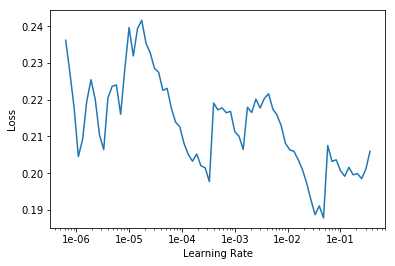

In [25]:
learn_cls.freeze()
lr_find(learn_cls)
learn_cls.recorder.plot()

In [56]:
learn_cls.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.001076,0.000839,0.937520


In [57]:
learn_cls.fit_one_cycle(3, 1e-2, moms=(0.8,0.7), pct_start=0.2)

epoch,train_loss,valid_loss,accuracy
1,0.001292,0.005078,0.937160
2,0.001013,0.001033,0.937040
3,0.001002,0.011955,0.936520


In [ ]:
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2, slice(1e-2/2.6,1e-2), moms=(0.8,0.7), pct_start=0.1)

In [ ]:
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-2/(2.6**2),3e-2), moms=(0.8,0.7), pct_start=0.1)

## Investigate mis-labeled cases in train set. 
Are they marginal reviews?  Other details that could be better addressed?

In [160]:
learn_cls.load('final')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (25000 items)
[Category 0, Category 0, Category 1, Category 0, Category 1]...
Path: /home/farzin/rnn_python_code/wiki103_from_download/clas
x: TextList (25000 items)
[Text xxbos another trashy grade z quickie from the prolific albert pyun . tim xxunk 13 inch clint eastwood - like cop from outer space chases an ugly flying head ( ! ) to earth and gets involved in a gang war in south bronx ! mercifully short , but xxunk dull , with the cheesiest effects since attack of the 50 ft woman . they should have fired the continuity guy , too : note how xxunk sunglasses disappears and reappears in every second shot . laughably bad , but that´s why we watch these movies , xxunk it ? sequel ´ dollman vs. demonic toys ´ is reportedly even worse , if that´s possible . 

 0 ( of xxrep 4 * ) 

, Text xxbos this show stinks . for parents , they usually want their kids to watch something good for them . it is usually educational , funny

In [ ]:
learn_cls.data.batch_size = 8

In [ ]:
DatasetType.Fix

In [183]:
y_hat, y_true = learn_cls.get_preds(DatasetType.Valid,ordered=True)
trn_df = CLS_valid_df.copy()

In [184]:
y_hat = F.softmax(y_hat,dim=1)

In [185]:
trn_df['pred0'] = to_np(y_hat)[:,0]
trn_df['pred1'] = to_np(y_hat)[:,1]
trn_df['pred_label']= to_np(y_hat).argmax(axis=1)

In [186]:
to_np(y_true)[:20]

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0])

In [187]:
trn_df.labels.values[:20]

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0])

In [188]:
trn_df.head()

,labels,text,rating,pred0,pred1,pred_label
0,0,I thought it will be a Ok movie after seeing t...,1,0.578663,0.421337,0
1,0,"I enjoyed Carax's ""Les Amants du Pont Neuf"" an...",4,0.992695,0.007305,0
2,1,What's the matter with you people? John Dahl? ...,10,0.014429,0.985571,1
3,0,Johnnie (Bert Wheeler) is a would-be songwrite...,3,0.993896,0.006104,0
4,1,This film has the guts to suggest that it migh...,8,0.004395,0.995605,1


Indeed, many of the marginal ratings (4 & 7) are a greater % of the errors

In [190]:
1.-(trn_df.pred_label != trn_df.labels).sum()/len(trn_df)

0.9386

In [191]:
trn_df[trn_df.pred_label != trn_df.labels].rating.value_counts().sort_index()

1     142
2      95
3     152
4     337
7     318
8     180
9     107
10    204
Name: rating, dtype: int64

In [192]:
trn_df[trn_df.pred_label != trn_df.labels].rating.value_counts().sort_index() / trn_df.rating.value_counts().sort_index()

1     0.028276
2     0.041268
3     0.059819
4     0.127894
7     0.137841
8     0.063158
9     0.045648
10    0.040808
Name: rating, dtype: float64

## Bwd Preds averaged

In [193]:
bwd_trn_df = pd.read_csv('bwd_training_classification.csv',index_col=0)

In [194]:
bwd_trn_df.head()

,labels,text,rating,pred0,pred1,pred_label
0,0,I thought it will be a Ok movie after seeing t...,1,0.906678,0.093322,0
1,0,"I enjoyed Carax's ""Les Amants du Pont Neuf"" an...",4,0.994287,0.005713,0
2,1,What's the matter with you people? John Dahl? ...,10,0.016465,0.983535,1
3,0,Johnnie (Bert Wheeler) is a would-be songwrite...,3,0.898954,0.101046,0
4,1,This film has the guts to suggest that it migh...,8,0.002427,0.997573,1


In [195]:
trn_df['ens0'] = 0.5*(bwd_trn_df['pred0']+trn_df['pred0'])
trn_df['ens1'] = 0.5*(bwd_trn_df['pred1']+trn_df['pred1'])

In [196]:
trn_df['ens_pred'] = trn_df[['ens0','ens1']].values.argmax(axis=1)

In [197]:
1.-(trn_df.ens_pred != trn_df.labels).sum()/len(trn_df)

0.94084

In [198]:
trn_df[trn_df.pred_label != trn_df.labels].rating.value_counts().sort_index()

1     142
2      95
3     152
4     337
7     318
8     180
9     107
10    204
Name: rating, dtype: int64

In [199]:
trn_df[trn_df.pred_label != trn_df.labels].rating.value_counts().sort_index() / trn_df.rating.value_counts().sort_index()

1     0.028276
2     0.041268
3     0.059819
4     0.127894
7     0.137841
8     0.063158
9     0.045648
10    0.040808
Name: rating, dtype: float64

In [50]:
trn_df[trn_df.pred_label != trn_df.labels].rating.value_counts().sort_index()

1     166
2     107
3     178
4     363
7     157
8      86
9      31
10     84
Name: rating, dtype: int64

In [51]:
trn_df.rating.value_counts().sort_index()

1     5100
2     2284
3     2420
4     2696
7     2496
8     3009
9     2263
10    4732
Name: rating, dtype: int64

In [52]:
trn_df[trn_df.pred_label != trn_df.labels].rating.value_counts().sort_index() / trn_df.rating.value_counts().sort_index()

1     0.032549
2     0.046848
3     0.073554
4     0.134644
7     0.062901
8     0.028581
9     0.013699
10    0.017751
Name: rating, dtype: float64

FocalLoss?  Can we just apply more error to the cases in the training that are near the margin?

In [ ]:
150/5000

In [ ]:
203/5000

In [ ]:
trn_df.shape